
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
DATASET = 'b2w'

#Dropout: 0, 10%
DROPOUT = 0

#Learning rate: 2.5e-5, 5e-5
LEARNING_RATE = 2.5e-5

FOLDS = 10

TRAIN_NUM = '01'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [5]:
df = pd.read_csv(f'../datasets/{DATASET}_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [7]:
print(f'dataset preprocessado e balanceado: {DATASET} -> {df.shape[0]} instancias')

dataset preprocessado e balanceado: b2w -> 71516 instancias


In [8]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

#### Tentativa de treinamento com 10% do dataset

In [16]:
#bach_01_text_train, bach_01_text_test, bach_01_labels_train, bach_01_labels_test = train_test_split(df['review_text'], df['rating'], train_size=0.1, random_state=42)

In [17]:
#print(f'{bach_01_text_train.shape[0]} para treinamento')

In [9]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

In [11]:
reviews = df['review_text']
labels = df['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [ ]:
embeddings = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing:  33%|███▎      | 23718/71516 [49:54<2:16:53,  5.82it/s] 

In [22]:
embeddings_array = np.vstack(embeddings)

In [23]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

133632 embeddings de 768 dimensões


#### Feature based 1

In [24]:
additional_features = np.array([[len(str(review).split())] for review in reviews])

In [25]:
print(embeddings_array.shape)
print(additional_features.shape)

(133632, 768)
(133632, 1)


#### Combinando embeddings_array e additional_features

In [26]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [27]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [28]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [29]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [76]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                18480     
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
CHECKPOINT=ModelCheckpoint(filepath='../weights/tlm_peq_fb1_weights.hdf5', verbose=0, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Cross-validation

In [79]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

#### Treinamento do modelo

In [80]:
fold = 0

fold_train_accuracies = []
fold_train_f1_scores = []

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
        
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score each fold
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # -----------------------------------------------------------------------------
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])

fold = 1
418/418 [==============================] - 0s 737us/step
fold = 2
418/418 [==============================] - 0s 719us/step
fold = 3
418/418 [==============================] - 0s 733us/step
fold = 4
418/418 [==============================] - 0s 744us/step
fold = 5
418/418 [==============================] - 0s 734us/step
fold = 6
418/418 [==============================] - 0s 735us/step
fold = 7
418/418 [==============================] - 0s 733us/step
fold = 8
418/418 [==============================] - 0s 782us/step
fold = 9
418/418 [==============================] - 0s 771us/step
fold = 10
418/418 [==============================] - 0s 830us/step


In [81]:
train_accuracy_mean_value = round(np.mean([np.mean(train_ac) for train_ac in fold_train_accuracies]),4)
train_f1_mean_value = round(np.mean([np.mean(train_f1) for train_f1 in fold_train_f1_scores]),4)
print(f"Media Accuracy Treino: {train_accuracy_mean_value}")
print(f"Media f1 score Treino: {train_f1_mean_value}")
print('-'*80)
print("Media Accuracy Validacao:", np.mean(fold_accuracies))
print("Media f1 score Validacao", np.mean(fold_f1_scores))

Media Accuracy Treino: 0.8579
Media f1 score Treino: 0.8717
--------------------------------------------------------------------------------
Media Accuracy Validacao: 0.8660354019325857
Media f1 score Validacao 0.8715359675687102


In [115]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

45/45 [==============================] - 0s 1ms/step - loss: 0.1413 - accuracy: 0.9518


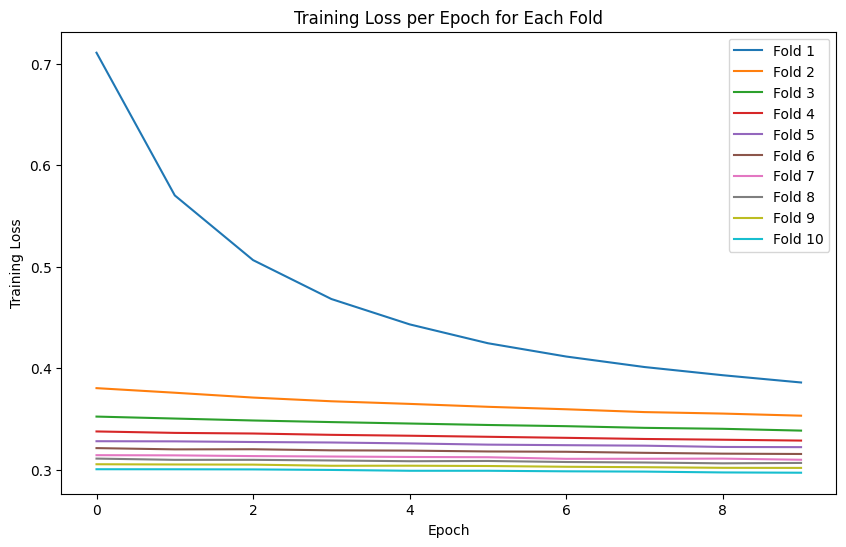

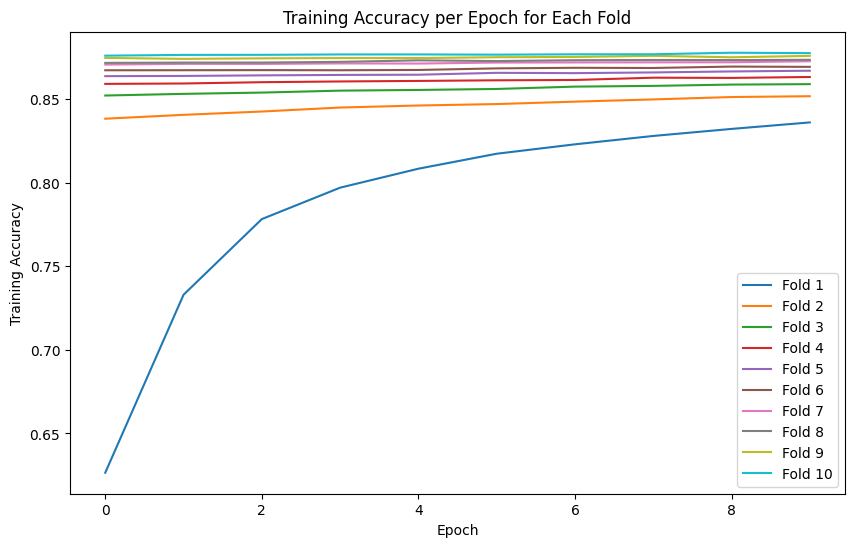

In [82]:
plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.savefig(f'./graphs/tlm_peq_fb1_mlp_loss_train_01.png')
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.savefig(f'./graphs/tlm_peq_fb1_mlp_accuracy_train_01.png')
plt.show()